In [1]:
# runs in jupyter container on node-eval-offline
import os
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from PIL import Image

In [2]:
os.listdir("/mnt/font-detector/models/")

['finetuned_n10.pt', 'finetuned_n100.pt']

In [3]:
class DeepFontAutoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 64, 12, 2, 1), torch.nn.ReLU(inplace=True),
            torch.nn.BatchNorm2d(64), torch.nn.MaxPool2d(2, 2),
            torch.nn.Conv2d(64, 128, 3, 1, 1), torch.nn.ReLU(inplace=True),
            torch.nn.BatchNorm2d(128), torch.nn.MaxPool2d(2, 2),
        )

class DeepFont(torch.nn.Module):
    def __init__(self, ae_encoder: torch.nn.Sequential, num_classes: int):
        super().__init__()
        self.ae_encoder = ae_encoder
        self.conv5 = torch.nn.Conv2d(128, 256, 3, 1, 1)
        self.conv6 = torch.nn.Conv2d(256, 256, 3, 1, 1)
        self.conv7 = torch.nn.Conv2d(256, 256, 3, 1, 1)
        self.flatten = torch.nn.Flatten()
        self.fc1 = torch.nn.Linear(256 * 12 * 12, 4096)
        self.drop1 = torch.nn.Dropout(0.5)
        self.fc2 = torch.nn.Linear(4096, 4096)
        self.drop2 = torch.nn.Dropout(0.5)
        self.fc3 = torch.nn.Linear(4096, 10)  # assuming 100 fonts

    def forward(self, x):
        x = self.ae_encoder(x)
        x = torch.relu(self.conv5(x))
        x = torch.relu(self.conv6(x))
        x = torch.relu(self.conv7(x))
        x = self.flatten(x)
        x = self.drop1(torch.relu(self.fc1(x)))
        x = self.drop2(torch.relu(self.fc2(x)))
        return self.fc3(x)

In [4]:
# runs in jupyter container on node-eval-offline
model_path = "/mnt/font-detector/models/finetuned_n10.pt"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ae = DeepFontAutoencoder()
model = DeepFont(ae.encoder, num_classes=10)  # or 25 if you're using the canary model

state_dict = torch.load(model_path, map_location=device)
missing, unexpected = model.load_state_dict(state_dict, strict=False)
print("Missing keys:", missing)
print("Unexpected keys:", unexpected)

model.to(device)
model.eval()

/tmp/ipykernel_18945/3588988400.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


Missing keys: []
Unexpected keys: []


DeepFont(
  (ae_encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(12, 12), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=36864, out_features=4096, bias=True)
  (drop1): Dropout(p=0.5, inplace=False)
  (fc2): Linea

In [5]:
# ───────────── deterministic preprocessing ─────────────────
class ResizeHeight:
    """Resize so the height equals `height`, keep aspect ratio."""
    def __init__(self, height: int = 105):
        self.height = height

    def __call__(self, img: Image.Image) -> Image.Image:
        w, h = img.size
        if h == 0:
            return Image.new(img.mode, (1, self.height), 255)
        new_w = max(1, round(self.height * w / h))
        return img.resize((new_w, self.height), Image.LANCZOS)


class Squeezing:
    """Deterministically squeeze horizontally by a fixed factor."""
    def __init__(self, ratio: float = 2.5):
        self.ratio = ratio

    def __call__(self, img: Image.Image) -> Image.Image:
        _, h = img.size
        return img.resize((max(1, round(h * self.ratio)), h),
                          Image.LANCZOS)

class CenterPatch:
    """Extract (or pad) a centred width-`step` patch."""
    def __init__(self, step: int = 105):
        self.step = step

    @staticmethod
    def _pad(img: Image.Image, width: int) -> Image.Image:
        w, h = img.size
        if w >= width:
            return img
        canvas = Image.new(img.mode, (width, h), 255)
        canvas.paste(img, (0, 0))
        return canvas

    def __call__(self, img: Image.Image) -> Image.Image:
        img = self._pad(img, self.step)
        w, h = img.size
        if w == self.step:
            return img
        sx = (w - self.step) // 2
        tile = img.crop((sx, 0, sx + self.step, h))
        return tile


In [6]:
# runs in jupyter container on node-eval-offline
from torch.utils.data import Dataset
from PIL import Image

font_data_dir = os.getenv("FONT_DATA_DIR", "/mnt/evaluation_filtered")
subset_font_path = "/home/jovyan/work/fontsubset.txt"

# Load font name to index map
with open(subset_font_path) as f:
    font_list = [line.strip() for line in f if line.strip()]
font_to_index = {name: idx for idx, name in enumerate(font_list)}

val_test_transform = transforms.Compose([
    ResizeHeight(105),
    Squeezing(),
    CenterPatch(step=105),
    transforms.Grayscale(1),
    transforms.ToTensor(),
])



class FontDataset(Dataset):
    def __init__(self, img_dir, transform, font_to_index):
        self.img_dir = img_dir
        self.transform = transform
        self.font_to_index = font_to_index
        self.image_files = [f for f in os.listdir(img_dir) if f.endswith(".png")]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_filename = self.image_files[idx]
        txt_filename = img_filename.replace(".png", ".txt")

        img_path = os.path.join(self.img_dir, img_filename)
        txt_path = os.path.join(self.img_dir, txt_filename)

        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        with open(txt_path) as f:
            font_name = f.read().strip()

        label = self.font_to_index[font_name]
        return image, label

test_dataset = FontDataset(font_data_dir, val_test_transform, font_to_index)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [7]:
# Ensure model is on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

# Preallocate arrays
dataset_size = len(test_loader.dataset)
all_predictions = np.empty(dataset_size, dtype=np.int64)
all_labels = np.empty(dataset_size, dtype=np.int64)

# Evaluation loop
current_index = 0

with torch.no_grad():
    for images, labels in test_loader:
        batch_size = labels.size(0)

        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_predictions[current_index:current_index + batch_size] = predicted.cpu().numpy()
        all_labels[current_index:current_index + batch_size] = labels.cpu().numpy()
        current_index += batch_size


In [8]:
# runs in jupyter container on node-eval-offline
overall_accuracy = (all_predictions == all_labels).sum() / all_labels.shape[0] * 100
print(f'Overall Accuracy: {overall_accuracy:.2f}%')

Overall Accuracy: 2.11%


In [9]:
# runs in jupyter container on node-eval-offline
with open("/home/jovyan/work/fontsubset.txt", "r") as f:
    classes = np.array([line.strip() for line in f if line.strip()])

num_classes = classes.shape[0]


In [10]:
# runs in jupyter container on node-eval-offline
per_class_correct = np.zeros(num_classes, dtype=np.int32)
per_class_total = np.zeros(num_classes, dtype=np.int32)

for true_label, pred_label in zip(all_labels, all_predictions):
    per_class_total[true_label] += 1
    per_class_correct[true_label] += int(true_label == pred_label)

for i in range(num_classes):
    if per_class_total[i] > 0:
        acc = per_class_correct[i] / per_class_total[i] * 100
        correct_str = f"{per_class_correct[i]}/{per_class_total[i]}"
        print(f"{classes[i]:<20} {acc:10.2f}% {correct_str:>20}")

AmigoStd                   0.00%                  0/1
AnnaStd                   20.00%                10/50
ApolloMTStd              100.00%                  1/1
AshleyScriptMTStd         42.86%                  3/7
BakerSignetStd             0.00%                  0/2
BalzanoStd                 0.00%                  0/3
BancoStd                   0.00%                 0/33
BansheeStd                 0.00%                  0/3
BeeskneesStd               0.00%                  0/5
BemboStd                   0.00%                 0/17
BiffoMTStd                 0.00%                  0/4
BodoniStd                  0.00%                  0/7
BossaNovaMVBStd            0.00%                  0/3
BrunoJBStd                 0.00%                  0/3
BrushScriptStd             0.00%                 0/14
CalibanStd                 0.00%                  0/3
CantoriaMTStd              0.00%                  0/5
CarolinaLTStd              0.00%                  0/3
CascadeScriptLTStd         0

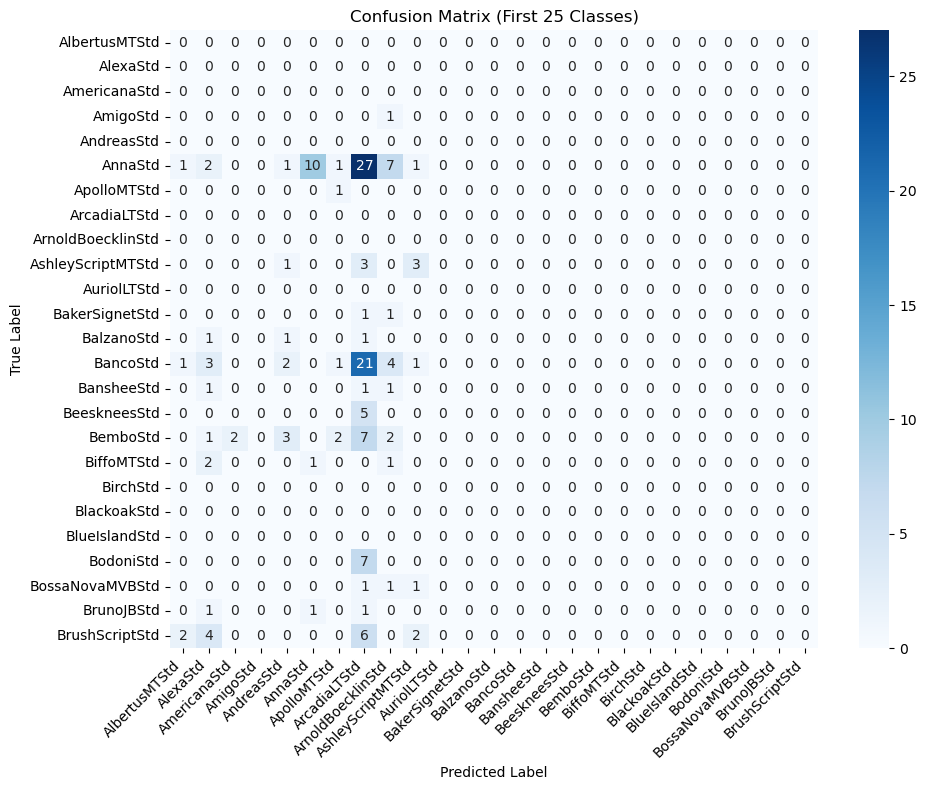

In [11]:
# runs in jupyter container on node-eval-offline

# Initialize full confusion matrix
conf_matrix = np.zeros((num_classes, num_classes), dtype=np.int32)

# Fill it using your predictions
for true_label, pred_label in zip(all_labels, all_predictions):
    conf_matrix[true_label, pred_label] += 1

# Select first 25 class indices (change this as needed)
subset_indices = list(range(25))
subset_matrix = conf_matrix[np.ix_(subset_indices, subset_indices)]
subset_class_names = [classes[i] for i in subset_indices]

# Plot the 5x5 heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(subset_matrix, annot=True, fmt='d',
            xticklabels=subset_class_names,
            yticklabels=subset_class_names,
            cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (First 25 Classes)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [12]:
# runs in jupyter container on node-eval-offline

font_1 = "CourierStd"
font_2 = "AmigoStd"

font1_index = np.where(classes == font_1)[0][0]
font2_index = np.where(classes == font_2)[0][0]

confused_indices = [i for i, (t, p) in enumerate(zip(all_labels, all_predictions))
                    if (t == font1_index and p == font2_index) or (t == font2_index and p == font1_index)]

sample_indices = np.random.choice(confused_indices, size=min(5, len(confused_indices)), replace=False)

# For controlled demo/discussion, override with hardcoded indices (optional)
# sample_indices = np.array([404, 927, 496, 435, 667])  # ← only use this if you know these exist in your data


In [13]:
# runs in jupyter container on node-eval-offline

sample_images = []
global_index = 0

for images, _ in test_loader:
    batch_size = images.size(0)
    for idx in sample_indices:
        if global_index <= idx < global_index + batch_size:
            image = images[idx - global_index].cpu()
            sample_images.append((idx, image))
    global_index += batch_size
    if len(sample_images) == len(sample_indices):
        break


In [14]:
# runs in jupyter container on node-eval-offline
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])
# Visualize those samples (undo the normalization first)
plt.figure(figsize=(12, 3))
for i, (idx, image) in enumerate(sample_images):
    image = image * std[:, None, None] + mean[:, None, None]  # unnormalize
    image = torch.clamp(image, 0, 1)
    image = image.permute(1, 2, 0)  # go from "channels, height, width" format to "height, width, channels"
    plt.subplot(1, len(sample_images), i + 1)
    plt.imshow(image)
    plt.title(f"True: {classes[all_labels[idx]]}\nPred: {classes[all_predictions[idx]]}\nIndex: {idx}")
    plt.axis('off')
plt.tight_layout()
plt.show()

<Figure size 1200x300 with 0 Axes>

In [15]:
# runs in jupyter container on node-eval-offline
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# GradCAM setup
target_layer = model.conv7
cam = GradCAM(model=model, target_layers=[target_layer])

In [16]:
# runs in jupyter container on node-eval-offline

mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

plt.figure(figsize=(12, 3))
for i, (idx, image) in enumerate(sample_images):
    input_tensor = (image.clone() - mean[:, None, None]) / std[:, None, None]  # normalize
    input_tensor = input_tensor.unsqueeze(0)  # add batch dim

    target_category = int(all_predictions[idx])
    grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(target_category)])
    grayscale_cam = grayscale_cam[0, :]

    image_disp = image * std[:, None, None] + mean[:, None, None]  # unnormalize
    image_disp = torch.clamp(image_disp, 0, 1).permute(1, 2, 0).numpy()

    visualization = show_cam_on_image(image_disp, grayscale_cam, use_rgb=True)
    plt.subplot(1, len(sample_images), i + 1)
    plt.imshow(visualization)
    plt.title(f"True: {classes[all_labels[idx]]}\nPred: {classes[all_predictions[idx]]}\nIndex: {idx}")
    plt.axis('off')
plt.tight_layout()
plt.show()

<Figure size 1200x300 with 0 Axes>

template based tests

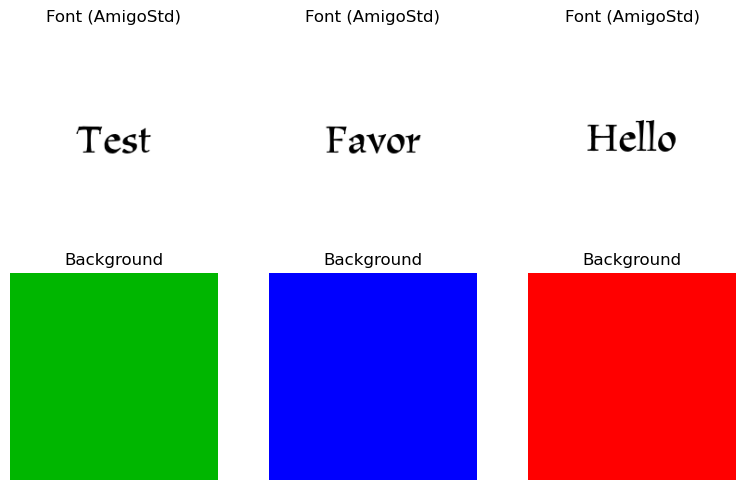

In [17]:
# runs in jupyter container on node-eval-offline

TEMPLATE_DIR = "templates"

fig, axes = plt.subplots(2, 3, figsize=(8, 5))

# Fonts row
font_dir = os.path.join(TEMPLATE_DIR, "fonts")
font_classes = [d for d in os.listdir(font_dir) if os.listdir(os.path.join(font_dir, d))]
random_font = random.choice(font_classes)
font_images = random.sample(os.listdir(os.path.join(font_dir, random_font)), 3)
font_paths = [os.path.join(font_dir, random_font, f) for f in font_images]

for i, path in enumerate(font_paths):
    axes[0, i].imshow(Image.open(path))
    axes[0, i].set_title(f"Font ({random_font})")
    axes[0, i].axis("off")

# Backgrounds row
bg_dir = os.path.join(TEMPLATE_DIR, "background")
bg_images = random.sample(os.listdir(bg_dir), 3)
bg_paths = [os.path.join(bg_dir, f) for f in bg_images]

for i, path in enumerate(bg_paths):
    axes[1, i].imshow(Image.open(path))
    axes[1, i].set_title("Background")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()


In [18]:
def compose_font_image(font_path, bg_path=None, extra_path=None):
    """
    Composes a font image with optional background and optional overlay.
    All inputs are image file paths.
    Returns a final composited RGB image.
    """

    # Load the font image and convert to RGBA
    font_img = Image.open(font_path).convert("RGBA")

    # Background setup
    if bg_path:
        bg = Image.open(bg_path).convert("RGBA").resize(font_img.size)
    else:
        bg = Image.new("RGBA", font_img.size, (255, 255, 255, 255))

    bg_w, bg_h = bg.size
    y_offset = int(bg_h * 0.05)
    # Resize font image (scale down slightly)
    font_scale = 0.8
    font_img = font_img.resize((int(bg_w * font_scale), int(bg_h * font_scale)))
    ft_w, ft_h = font_img.size

    # Paste font image last (so it appears above the extras)
    bg.paste(font_img, ((bg_w - ft_w) // 2, bg_h - ft_h - y_offset), font_img)
    # Optional overlay (e.g., emoji, occlusion, sticker)
    if extra_path:
        extra_scale = 0.35
        extra = Image.open(extra_path).convert("RGBA")
        extra = extra.resize((int(bg_w * extra_scale), int(bg_h * extra_scale)))
        ex_w, ex_h = extra.size
        bg.paste(extra, (bg_w - ex_w, bg_h - ex_h - y_offset), extra)



    return bg.convert("RGB")


CourierStd

In [19]:
# runs in jupyter container on node-eval-offline

imgs = {
    'original_image': compose_font_image('templates/fonts/CourierStd/CourierStd_0.png'),
    'composed_bg1_extra1': compose_font_image('templates/fonts/CourierStd/CourierStd_0.png',
                                              'templates/background/001.png',
                                              'templates/extras/smiley_face.png'),
    'composed_bg2_extra2': compose_font_image('templates/fonts/CourierStd/CourierStd_0.png',
                                              'templates/background/002.png',
                                              'templates/extras/circle.png'),
    'composed_same_class': compose_font_image('templates/fonts/CourierStd/CourierStd_1.png',
                                              'templates/background/001.png'),
    'composed_diff_class': compose_font_image('templates/fonts/ImpactLTStd/ImpactLTStd_2.png',
                                              'templates/background/001.png')
}


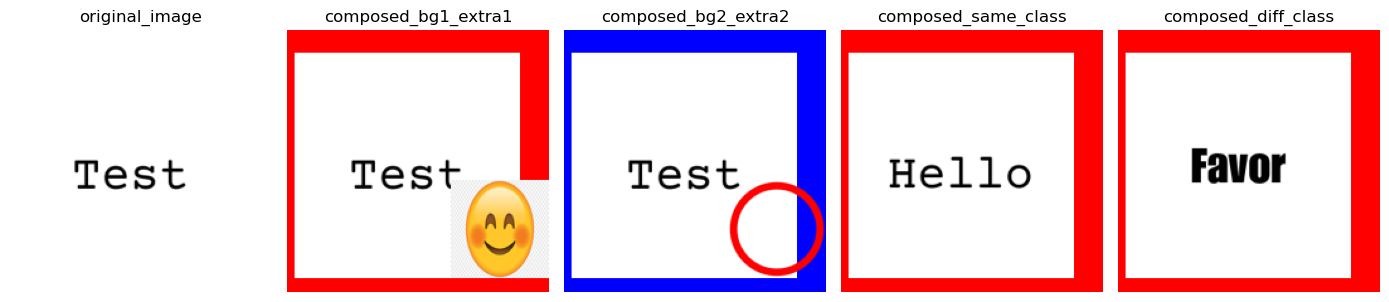

In [20]:
# runs in jupyter container on node-eval-offline

fig, axes = plt.subplots(1, 5, figsize=(14, 3))

for ax, key in zip(axes, imgs.keys()):
    ax.imshow(imgs[key].resize((224, 224)).crop((16, 16, 224, 224)))
    ax.set_title(f"{key}")
    ax.axis("off")

plt.tight_layout()
plt.show()


In [21]:
def predict(model, image, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    model.eval()
    image_tensor = val_test_transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image_tensor)
        return output.argmax(dim=1).item()


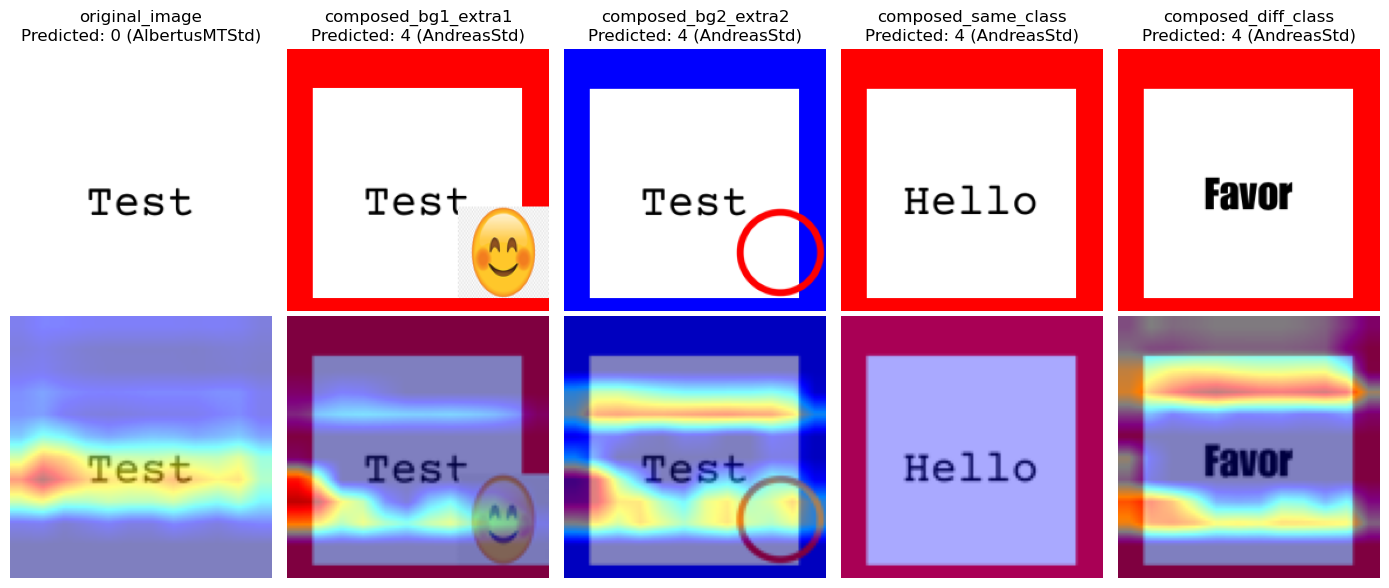

In [22]:
# runs in jupyter container on node-eval-offline

fig, axes = plt.subplots(2, 5, figsize=(14, 6))

for i, key in enumerate(imgs.keys()):
    image_np = np.array(imgs[key].resize((105, 105))).astype(dtype=np.float32) / 255.0
    pred = predict(model, imgs[key])

    input_tensor = val_test_transform(imgs[key]).unsqueeze(0)
    grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(pred)])[0]
    vis = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)

    axes[0, i].imshow(imgs[key].resize((224, 224)))
    axes[0, i].set_title(f"{key}\nPredicted: {pred} ({classes[pred]})")
    axes[0, i].axis("off")

    axes[1, i].imshow(vis)
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()

AmigoStd

In [23]:
imgs = {
    'original_image': compose_font_image('templates/fonts/AmigoStd/AmigoStd_0.png'),
    'composed_bg1_extra1': compose_font_image('templates/fonts/AmigoStd/AmigoStd_0.png',
                                              'templates/background/003.png',
                                              'templates/extras/smiley_face.png'),
    'composed_bg2_extra2': compose_font_image('templates/fonts/AmigoStd/AmigoStd_0.png',
                                              'templates/background/002.png',
                                              'templates/extras/arrow.png'),
    'composed_same_class': compose_font_image('templates/fonts/AmigoStd/AmigoStd_1.png',
                                              'templates/background/003.png'),
    'composed_diff_class': compose_font_image('templates/fonts/CourierStd/CourierStd_2.png',
                                              'templates/background/003.png')
}


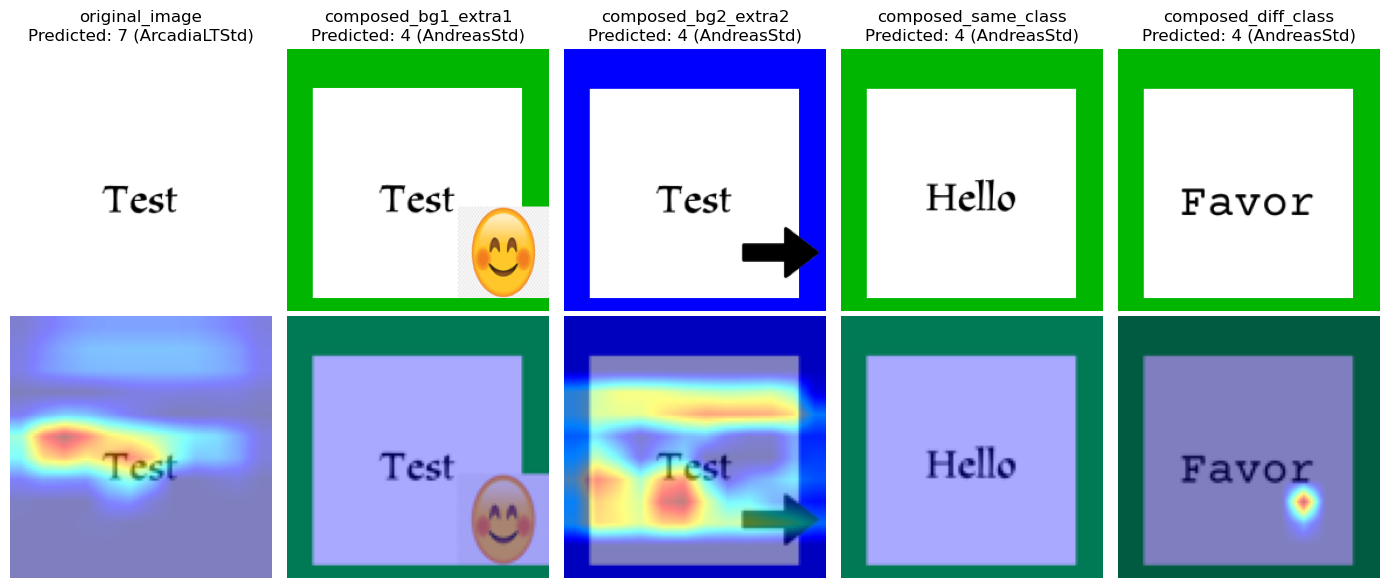

In [24]:
# runs in jupyter container on node-eval-offline

fig, axes = plt.subplots(2, 5, figsize=(14, 6))

for i, key in enumerate(imgs.keys()):
    image_np = np.array(imgs[key].resize((105, 105))).astype(dtype=np.float32) / 255.0
    pred = predict(model, imgs[key])

    input_tensor = val_test_transform(imgs[key]).unsqueeze(0)
    grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(pred)])[0]
    vis = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)

    axes[0, i].imshow(imgs[key].resize((224, 224)))
    axes[0, i].set_title(f"{key}\nPredicted: {pred} ({classes[pred]})")
    axes[0, i].axis("off")

    axes[1, i].imshow(vis)
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()

Impact

In [25]:
imgs = {
    'original_image': compose_font_image('templates/fonts/ImpactLTStd/ImpactLTStd_0.png'),
    'composed_bg1_extra1': compose_font_image('templates/fonts/ImpactLTStd/ImpactLTStd_0.png',
                                              'templates/background/003.png',
                                              'templates/extras/smiley_face.png'),
    'composed_bg2_extra2': compose_font_image('templates/fonts/ImpactLTStd/ImpactLTStd_0.png',
                                              'templates/background/002.png',
                                              'templates/extras/arrow.png'),
    'composed_same_class': compose_font_image('templates/fonts/ImpactLTStd/ImpactLTStd_1.png',
                                              'templates/background/003.png'),
    'composed_diff_class': compose_font_image('templates/fonts/AmigoStd/AmigoStd_2.png',
                                              'templates/background/003.png')
}


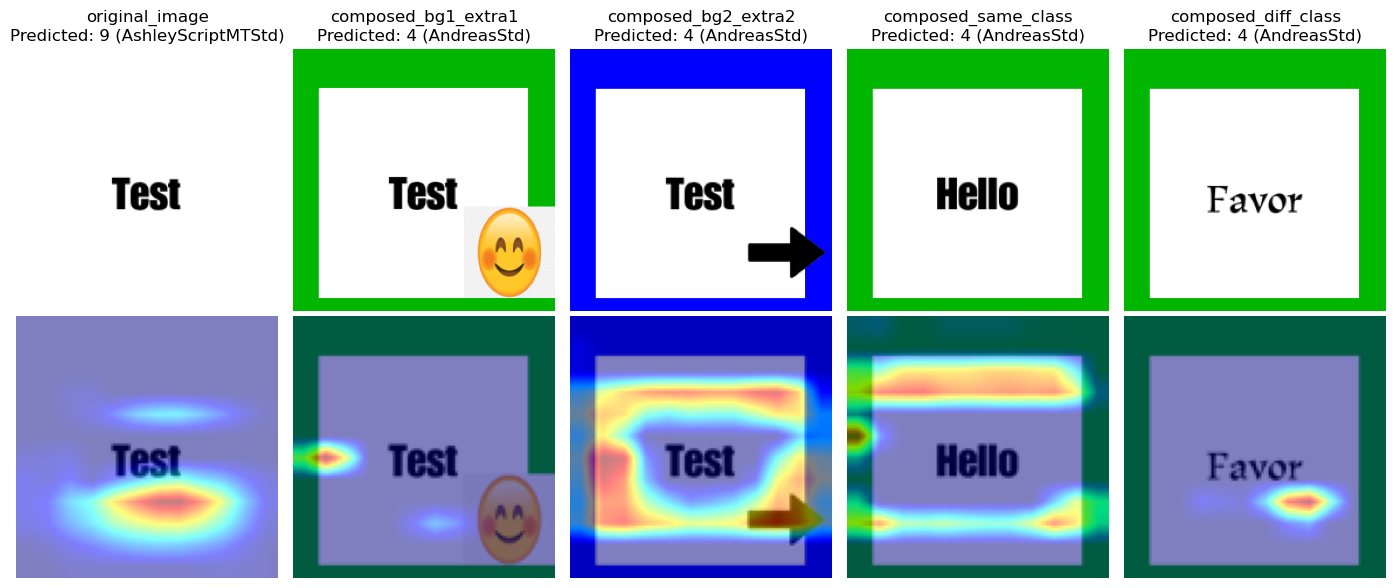

In [26]:
# runs in jupyter container on node-eval-offline

fig, axes = plt.subplots(2, 5, figsize=(14, 6))

for i, key in enumerate(imgs.keys()):
    image_np = np.array(imgs[key].resize((105, 105))).astype(dtype=np.float32) / 255.0
    pred = predict(model, imgs[key])

    input_tensor = val_test_transform(imgs[key]).unsqueeze(0)
    grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(pred)])[0]
    vis = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)

    axes[0, i].imshow(imgs[key].resize((224, 224)))
    axes[0, i].set_title(f"{key}\nPredicted: {pred} ({classes[pred]})")
    axes[0, i].axis("off")

    axes[1, i].imshow(vis)
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()

Looks like test

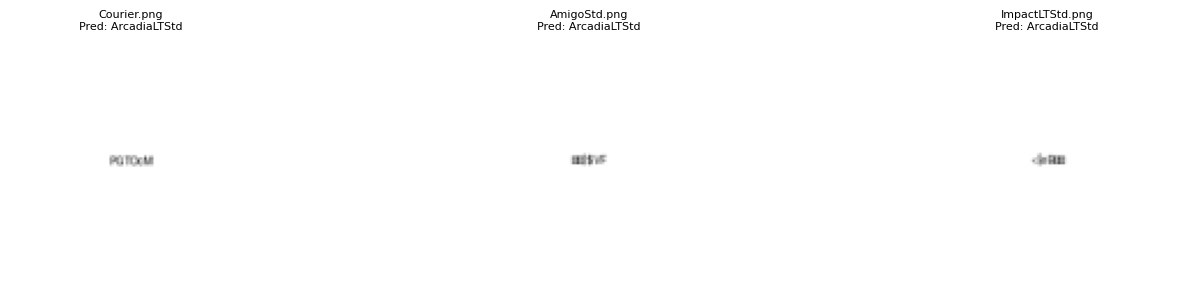

In [27]:
# runs in jupyter container on node-eval-offline

gibberish_dir = "gibberish_looks_like"
images = [f for f in os.listdir(gibberish_dir) if f.endswith(".png")]

if not images:
    raise ValueError("No PNG images found in gibberish_looks_like folder.")

# Sample all or up to 5
selected_images = random.sample(images, min(5, len(images)))

# Plot the selected gibberish samples
fig, axes = plt.subplots(1, len(selected_images), figsize=(5 * len(selected_images), 3))

for ax, img_name in zip(axes, selected_images):
    img_path = os.path.join(gibberish_dir, img_name)
    image = Image.open(img_path).convert("RGB")
    pred = predict(model, image)

    ax.imshow(image.resize((105, 105)))
    ax.set_title(f"{img_name}\nPred: {classes[pred]}", fontsize=8)
    ax.axis("off")

plt.tight_layout()
plt.show()


Test Suite

In [1]:
!pytest --verbose --tb=no tests/

============================= test session starts ==============================
platform linux -- Python 3.12.8, pytest-8.3.5, pluggy-1.5.0 -- /opt/conda/bin/python3.12
cachedir: .pytest_cache
rootdir: /home/jovyan/work
plugins: anyio-4.8.0
collected 4 items                                                              

PASSED [ 25%]es.py::test_gibberish_looks_like_accuracy 
FAILED        [ 50%]est_overall_accuracy 
tests/test_fontdetector_accuracy.py::test_per_class_accuracy FAILED      [ 75%]
FAILED   [100%]py::test_template_permutations 

=============================== warnings summary ===============================
tests/test_fondetector_test_cases.py::test_gibberish_looks_like_accuracy
  /home/jovyan/work/tests/conftest.py:142: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See h

In [2]:
# tests/test_fonts.py
def test_prediction_format():
    pred = model.predict(image)
    assert isinstance(pred, int)


In [3]:
!pytest --verbose --lf --tb=no tests/


============================= test session starts ==============================
platform linux -- Python 3.12.8, pytest-8.3.5, pluggy-1.5.0 -- /opt/conda/bin/python3.12
cachedir: .pytest_cache
rootdir: /home/jovyan/work
plugins: anyio-4.8.0
collected 3 items                                                              
run-last-failure: rerun previous 3 failures (skipped 1 file)

FAILED        [ 33%]est_overall_accuracy 
tests/test_fontdetector_accuracy.py::test_per_class_accuracy FAILED      [ 66%]
FAILED   [100%]py::test_template_permutations 

=============================== warnings summary ===============================
tests/test_fontdetector_accuracy.py::test_overall_accuracy
  /home/jovyan/work/tests/conftest.py:142: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://gi

In [4]:
!pytest --verbose --tb=no tests/test_fontdetector_test_cases.py


============================= test session starts ==============================
platform linux -- Python 3.12.8, pytest-8.3.5, pluggy-1.5.0 -- /opt/conda/bin/python3.12
cachedir: .pytest_cache
rootdir: /home/jovyan/work
plugins: anyio-4.8.0
collected 0 items                                                              

============================ no tests ran in 0.00s =============================
ERROR: file or directory not found: tests/test_fontdetector_test_cases.py

